Import important parameter

In [1]:
inputsize = 31**2
e = 0.05

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 16.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,16*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 16*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,16*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,16*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,16*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <1000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
error=10e-11
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*(1 + (2 + np.cos(np.pi*x))/(2 + np.cos(np.pi*y)) + (2 + np.cos(5*np.pi*x))/(2 + np.cos(5*np.pi*y)))*np.sin(3*np.pi*x)*np.sin(5*np.pi*y) - 3*np.pi*np.cos(3*np.pi*x)*(-((np.pi*np.sin(np.pi*x))/(2 + np.cos(np.pi*y))) - (5*np.pi*np.sin(5*np.pi*x))/(2 + np.cos(5*np.pi*y)))*np.sin(5*np.pi*y) - 5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*((np.pi*(2 + np.cos(np.pi*x))*np.sin(np.pi*y))/(2 + np.cos(np.pi*y))**2 + (5*np.pi*(2 + np.cos(5*np.pi*x))*np.sin(5*np.pi*y))/(2 + np.cos(5*np.pi*y))**2)
def a(x,y): return(1 + (2 + np.cos(np.pi*x))/(2 + np.cos(np.pi*y)) + (2 + np.cos(5*np.pi*x))/(2 + np.cos(5*np.pi*y)))

sqrtinputsize = int(np.sqrt(inputsize))
sqrtmidputsize = int(sqrtinputsize/2)
midputsize = int(sqrtmidputsize**2)
sqrtoutputsize = int(sqrtmidputsize/2)
outputsize = int(sqrtoutputsize**2)

h = 1/(sqrtinputsize-1)
H = 1/(sqrtoutputsize-1)
A0 = Poisson(inputsize)
num_levels=2
n=sqrtinputsize
kx = np.zeros([n,n+1])
ky = np.zeros([n+1,n])
for i in range(n):
    for j in range(n+1):
        kx[i][j] = a((j-0.5)*h,i*h)
for i in range(n+1):
    for j in range(n):
        ky[i][j] = a(j*h,(i-0.5)*h)    
A1 = gallery.nonlinearPoisson((n,n), kx, ky)
n = inputsize
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
Ureal = u_real(X,Y).reshape(inputsize, 1)
Media = a(X,Y)
R1 = Restriction(inputsize)
R2 = Restriction(midputsize)
R  = np.matmul(R2, R1)
P = 16*np.transpose(R)

GMM on fine grid

In [5]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, R, s, w, error)

Residual = 18.187264720211775
Interation = 1
Residual = 8.421319962452008
Interation = 2
Residual = 5.742536347638407
Interation = 3
Residual = 4.0385061801049975
Interation = 4
Residual = 2.8579297563709516
Interation = 5
Residual = 2.0319413458410374
Interation = 6
Residual = 1.4525281136323562
Interation = 7
Residual = 1.0446875831391116
Interation = 8
Residual = 0.7563091842095369
Interation = 9
Residual = 0.5513013342977593
Interation = 10
Residual = 0.40467587152817336
Interation = 11
Residual = 0.2991092629938469
Interation = 12
Residual = 0.22256532582808564
Interation = 13
Residual = 0.16665734041797914
Interation = 14
Residual = 0.12551996593362186
Interation = 15
Residual = 0.09503216896269598
Interation = 16
Residual = 0.07228201015687248
Interation = 17
Residual = 0.05519811220636192
Interation = 18
Residual = 0.04229588945058292
Interation = 19
Residual = 0.03250264761905955
Interation = 20
Residual = 0.025036778618495147
Interation = 21
Residual = 0.019324005448379696
In

Error GMM on fine grid

In [6]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
GMMU = GMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = GMMU - UREAL

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
2.7085481257054567
L2 norm: 
0.12589405933007888
H1 norm: 
1.468476129840555
Energy norm: 
0.1622985183749655
L2 norm: 
0.25178811866015777
H1 norm: 
0.1610233527988268


Solution

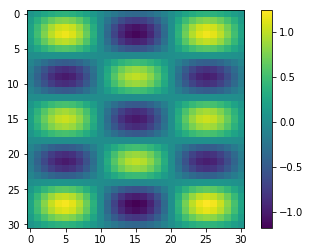

In [7]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

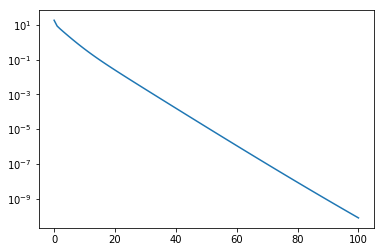

In [8]:
plt.semilogy(GMM_Res)

Radius

In [9]:
GMM_Radius = rho(inputsize,A1.to_full(),16*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.8333335561271714


Global DMM optimization

In [10]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, 
                                                           learning_rate = 1e-6,accept_radius =
                                                           GMM_Radius*10,step_length =  1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.8320418731203341
L = 0.03
rho = 0.8320528371452233
L = 0.04
rho = 0.8320651729602669
L = 0.05
rho = 0.8320786591370454
L = 0.060000000000000005
rho = 0.8320931078852426
L = 0.07
rho = 0.8321083593018331
L = 0.08
rho = 0.83212427674388
L = 0.09
rho = 0.832140743076524
L = 0.09999999999999999
rho = 0.8321576576090219
L = 0.10999999999999999
rho = 0.8321749335763285
L = 0.11999999999999998
rho = 0.8321924960566363
L = 0.12999999999999998
rho = 0.8322102802398308
L = 0.13999999999999999
rho = 0.8322282299803081
L = 0.15
rho = 0.8322462965816648
L = 0.16
rho = 0.8322644377715589
L = 0.17
rho = 0.8322826168333897
L = 0.18000000000000002
rho = 0.8323008018679474
L = 0.19000000000000003
rho = 0.8323189651632975
L = 0.20000000000000004
rho = 0.8323370826551989
L = 0.21000000000000005
rho = 0.8323551334635714
L = 0.22000000000000006
rho = 0.8323730994930959
L = 0.23000000000000007
rho = 0.8323909650881037
L = 0.24000000000000007
rho = 0.8324087167335801
L =

the 27 steps
rho = 0.8333184908000006
the 28 steps
rho = 0.8333183637711286
the 29 steps
rho = 0.8333182367478538
the 30 steps
rho = 0.8333181097301745
the 31 steps
rho = 0.8333179827180893
the 32 steps
rho = 0.8333178557115964
the 33 steps
rho = 0.8333177287106945
the 34 steps
rho = 0.8333176017153816
the 35 steps
rho = 0.8333174747256564
the 36 steps
rho = 0.8333173477415171
the 37 steps
rho = 0.8333172207629623
the 38 steps
rho = 0.8333170937899902
the 39 steps
rho = 0.8333169668225991
the 40 steps
rho = 0.8333168398607878
the 41 steps
rho = 0.8333167129045544
the 42 steps
rho = 0.8333165859538973
the 43 steps
rho = 0.833316459008815
the 44 steps
rho = 0.8333163320693059
the 45 steps
rho = 0.8333162051353683
the 46 steps
rho = 0.8333160782070006
the 47 steps
rho = 0.8333159512842013
the 48 steps
rho = 0.8333158243669687
the 49 steps
rho = 0.8333156974553013
the 50 steps
rho = 0.8333155705491975
the 51 steps
rho = 0.8333154436486556
the 52 steps
rho = 0.8333153167536741
the 53 steps


the 168 steps
rho = 0.8333006342461736
the 169 steps
rho = 0.8333005079908689
the 170 steps
rho = 0.8333003817409395
the 171 steps
rho = 0.833300255496384
the 172 steps
rho = 0.8333001292572009
the 173 steps
rho = 0.8333000030233887
the 174 steps
rho = 0.8332998767949458
the 175 steps
rho = 0.8332997505718707
the 176 steps
rho = 0.8332996243541618
the 177 steps
rho = 0.8332994981418177
the 178 steps
rho = 0.8332993719348367
the 179 steps
rho = 0.8332992457332173
the 180 steps
rho = 0.8332991195369582
the 181 steps
rho = 0.8332989933460576
the 182 steps
rho = 0.833298867160514
the 183 steps
rho = 0.833298740980326
the 184 steps
rho = 0.833298614805492
the 185 steps
rho = 0.8332984886360104
the 186 steps
rho = 0.8332983624718798
the 187 steps
rho = 0.8332982363130985
the 188 steps
rho = 0.8332981101596652
the 189 steps
rho = 0.8332979840115782
the 190 steps
rho = 0.833297857868836
the 191 steps
rho = 0.8332977317314372
the 192 steps
rho = 0.83329760559938
the 193 steps
rho = 0.8332974794

the 308 steps
rho = 0.833283010126376
the 309 steps
rho = 0.8332828846089007
the 310 steps
rho = 0.8332827590965903
the 311 steps
rho = 0.8332826335894435
the 312 steps
rho = 0.8332825080874589
the 313 steps
rho = 0.8332823825906348
the 314 steps
rho = 0.83328225709897
the 315 steps
rho = 0.8332821316124627
the 316 steps
rho = 0.8332820061311117
the 317 steps
rho = 0.8332818806549156
the 318 steps
rho = 0.8332817551838726
the 319 steps
rho = 0.8332816297179816
the 320 steps
rho = 0.8332815042572408
the 321 steps
rho = 0.833281378801649
the 322 steps
rho = 0.8332812533512045
the 323 steps
rho = 0.8332811279059061
the 324 steps
rho = 0.8332810024657522
the 325 steps
rho = 0.8332808770307413
the 326 steps
rho = 0.833280751600872
the 327 steps
rho = 0.8332806261761428
the 328 steps
rho = 0.8332805007565522
the 329 steps
rho = 0.833280375342099
the 330 steps
rho = 0.8332802499327814
the 331 steps
rho = 0.8332801245285981
the 332 steps
rho = 0.8332799991295475
the 333 steps
rho = 0.833279873

the 448 steps
rho = 0.8332654872851676
the 449 steps
rho = 0.8332653624767101
the 450 steps
rho = 0.8332652376732165
the 451 steps
rho = 0.8332651128746853
the 452 steps
rho = 0.8332649880811153
the 453 steps
rho = 0.8332648632925048
the 454 steps
rho = 0.8332647385088526
the 455 steps
rho = 0.8332646137301573
the 456 steps
rho = 0.8332644889564174
the 457 steps
rho = 0.8332643641876315
the 458 steps
rho = 0.8332642394237982
the 459 steps
rho = 0.8332641146649162
the 460 steps
rho = 0.8332639899109842
the 461 steps
rho = 0.8332638651620005
the 462 steps
rho = 0.8332637404179637
the 463 steps
rho = 0.8332636156788727
the 464 steps
rho = 0.833263490944726
the 465 steps
rho = 0.833263366215522
the 466 steps
rho = 0.8332632414912595
the 467 steps
rho = 0.833263116771937
the 468 steps
rho = 0.8332629920575532
the 469 steps
rho = 0.8332628673481066
the 470 steps
rho = 0.8332627426435959
the 471 steps
rho = 0.8332626179440197
the 472 steps
rho = 0.8332624932493765
the 473 steps
rho = 0.833262

the 588 steps
rho = 0.8332480617776769
the 589 steps
rho = 0.8332479376506925
the 590 steps
rho = 0.8332478135284798
the 591 steps
rho = 0.8332476894110372
the 592 steps
rho = 0.8332475652983635
the 593 steps
rho = 0.8332474411904572
the 594 steps
rho = 0.8332473170873171
the 595 steps
rho = 0.8332471929889419
the 596 steps
rho = 0.8332470688953302
the 597 steps
rho = 0.8332469448064805
the 598 steps
rho = 0.8332468207223916
the 599 steps
rho = 0.8332466966430623
the 600 steps
rho = 0.833246572568491
the 601 steps
rho = 0.8332464484986765
the 602 steps
rho = 0.8332463244336175
the 603 steps
rho = 0.8332462003733125
the 604 steps
rho = 0.8332460763177604
the 605 steps
rho = 0.8332459522669596
the 606 steps
rho = 0.833245828220909
the 607 steps
rho = 0.8332457041796071
the 608 steps
rho = 0.8332455801430526
the 609 steps
rho = 0.8332454561112442
the 610 steps
rho = 0.8332453320841806
the 611 steps
rho = 0.8332452080618604
the 612 steps
rho = 0.8332450840442822
the 613 steps
rho = 0.83324

the 728 steps
rho = 0.8332307298322669
the 729 steps
rho = 0.8332306063604191
the 730 steps
rho = 0.8332304828931588
the 731 steps
rho = 0.8332303594304848
the 732 steps
rho = 0.833230235972396
the 733 steps
rho = 0.8332301125188909
the 734 steps
rho = 0.8332299890699683
the 735 steps
rho = 0.8332298656256268
the 736 steps
rho = 0.8332297421858653
the 737 steps
rho = 0.8332296187506825
the 738 steps
rho = 0.8332294953200771
the 739 steps
rho = 0.8332293718940476
the 740 steps
rho = 0.8332292484725929
the 741 steps
rho = 0.8332291250557119
the 742 steps
rho = 0.833229001643403
the 743 steps
rho = 0.833228878235665
the 744 steps
rho = 0.8332287548324968
the 745 steps
rho = 0.833228631433897
the 746 steps
rho = 0.8332285080398643
the 747 steps
rho = 0.8332283846503973
the 748 steps
rho = 0.833228261265495
the 749 steps
rho = 0.8332281378851559
the 750 steps
rho = 0.8332280145093789
the 751 steps
rho = 0.8332278911381626
the 752 steps
rho = 0.8332277677715058
the 753 steps
rho = 0.83322764

the 868 steps
rho = 0.8332134878424929
the 869 steps
rho = 0.8332133650005967
the 870 steps
rho = 0.8332132421631123
the 871 steps
rho = 0.8332131193300384
the 872 steps
rho = 0.8332129965013737
the 873 steps
rho = 0.8332128736771172
the 874 steps
rho = 0.8332127508572673
the 875 steps
rho = 0.8332126280418232
the 876 steps
rho = 0.8332125052307834
the 877 steps
rho = 0.8332123824241467
the 878 steps
rho = 0.833212259621912
the 879 steps
rho = 0.833212136824078
the 880 steps
rho = 0.8332120140306436
the 881 steps
rho = 0.8332118912416072
the 882 steps
rho = 0.833211768456968
the 883 steps
rho = 0.8332116456767246
the 884 steps
rho = 0.8332115229008757
the 885 steps
rho = 0.8332114001294203
the 886 steps
rho = 0.8332112773623569
the 887 steps
rho = 0.8332111545996844
the 888 steps
rho = 0.8332110318414017
the 889 steps
rho = 0.8332109090875074
the 890 steps
rho = 0.8332107863380003
the 891 steps
rho = 0.8332106635928793
the 892 steps
rho = 0.8332105408521432
the 893 steps
rho = 0.833210

Global DMM on fine grid

In [11]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, error)

Residual = 18.186650312795948
Interation = 1
Residual = 8.418535831447945
Interation = 2
Residual = 5.740068034064604
Interation = 3
Residual = 4.036128396186468
Interation = 4
Residual = 2.8557579444520926
Interation = 5
Residual = 2.030054607690408
Interation = 6
Residual = 1.4509432654265135
Interation = 7
Residual = 1.0433851244959484
Interation = 8
Residual = 0.755253924138598
Interation = 9
Residual = 0.5504540888779773
Interation = 10
Residual = 0.4039993317588172
Interation = 11
Residual = 0.2985705472678974
Interation = 12
Residual = 0.22213673959724628
Interation = 13
Residual = 0.16631622127259502
Interation = 14
Residual = 0.12524811398432312
Interation = 15
Residual = 0.09481514014303878
Interation = 16
Residual = 0.07210841821569756
Interation = 17
Residual = 0.05505900743196173
Interation = 18
Residual = 0.04218423777445789
Interation = 19
Residual = 0.032412910032117895
Interation = 20
Residual = 0.02496457970030338
Interation = 21
Residual = 0.019265875969402012
Intera

Error DMM on fine grid

In [12]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
DMMU = DMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = DMMU - UREAL

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
2.708548125706232
L2 norm: 
0.1258940593301444
H1 norm: 
1.468476129841033
Energy norm: 
0.16229851837501197
L2 norm: 
0.2517881186602888
H1 norm: 
0.16102335279887917


Solution

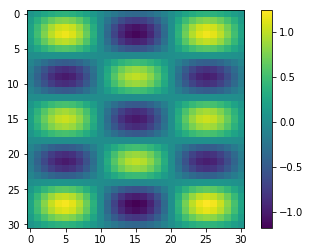

In [13]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

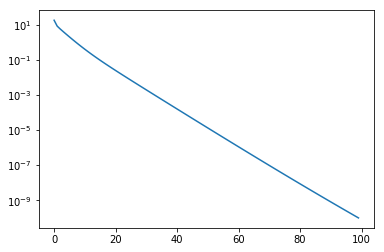

In [14]:
plt.semilogy(DMM_Res)

Radius

In [15]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.8331974326748888


Rrestriction matrix after optimization

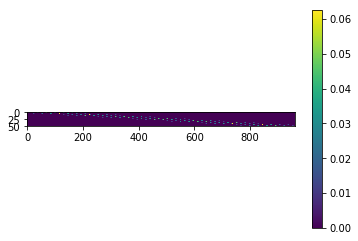

In [16]:
plt.imshow(Rnew)
plt.colorbar()

Rrestriction matrix (log(abs()) after optimization

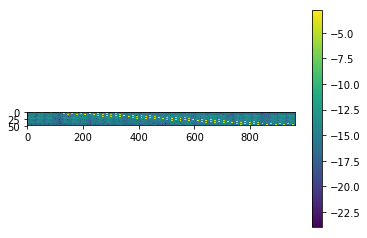

In [17]:
plt.imshow(np.log(np.abs(Rnew)))
plt.colorbar()

Basis after optimization

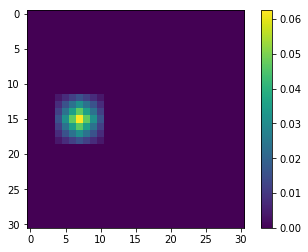

In [18]:
basis1 = Rnew[int(0.45*outputsize)][:]
basis1 = basis1.reshape([sqrtinputsize,sqrtinputsize])
plt.imshow(basis1)
plt.colorbar()

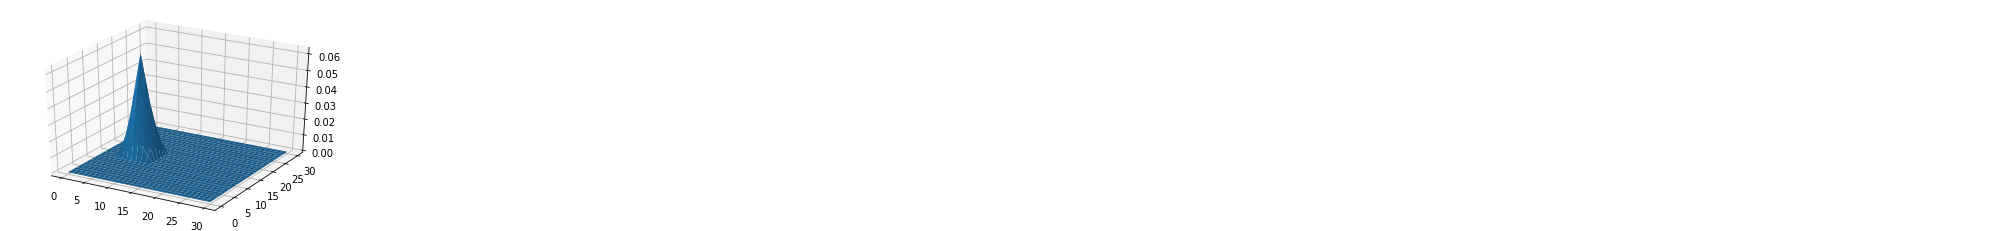

In [19]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
size=basis1.shape
Y=np.arange(0,size[0],1)     
X=np.arange(0,size[1],1)

X,Y=np.meshgrid(X,Y)    
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,basis1)
plt.show()

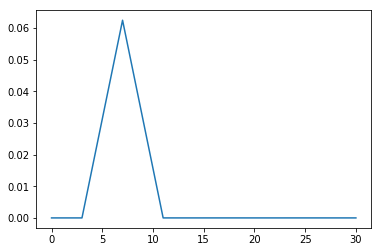

In [20]:
plt.plot(basis1[:][int(sqrtinputsize/2)])

Basis after optimization (log(abs()))

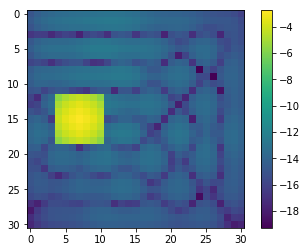

In [21]:
plt.imshow(np.log(np.abs(basis1)))
plt.colorbar()

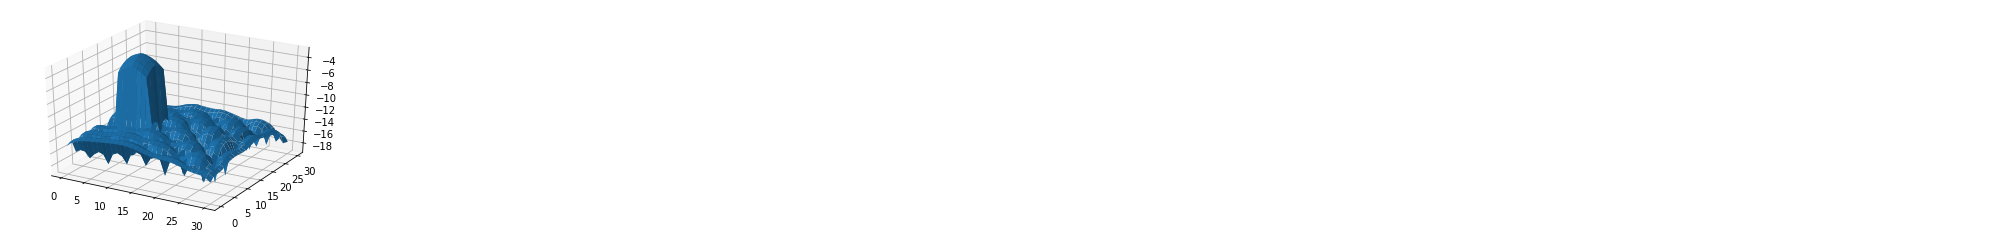

In [22]:
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,np.log(np.abs(basis1)))
plt.show()

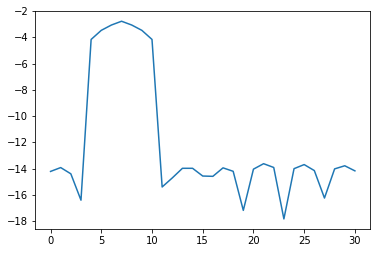

In [23]:
plt.plot(np.log(np.abs(basis1[:][int(sqrtinputsize/2)])))

FEM use basis from global DMM

Energy norm: 
7.319151784590888
L2 norm: 
0.19824083854859892
H1 norm: 
4.059011968395811
Energy norm: 
0.4385698297648648
L2 norm: 
0.3964816770971979
H1 norm: 
0.4450843312465865


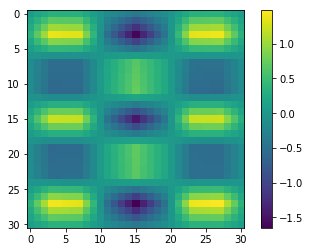

In [24]:

Anew = np.zeros([outputsize,outputsize])
[X1, Y1] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
[X2, Y2] = np.meshgrid(np.linspace(0, 1, sqrtoutputsize),np.linspace(0, 1, sqrtoutputsize))
A = a(X1,Y1)
for i in range(outputsize):
    for j in range(outputsize):
        basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
        basisj = Rnew[j][:].reshape([sqrtinputsize,sqrtinputsize])
        gxbasisi = np.gradient(basisi,axis=0)/h
        gybasisi = np.gradient(basisi,axis=1)/h
        gxbasisj = np.gradient(basisj,axis=0)/h
        gybasisj = np.gradient(basisj,axis=1)/h
        Anew[i][j]=(np.sum(A*gxbasisi*gxbasisj)+np.sum(A*gybasisi*gybasisj))*(H**2)
        
Fnew = np.zeros([outputsize,1])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    F = rightf(X1,Y1)
    Fnew[i]=np.sum(F*basisi)*(H**2)
    
UnewCoarse = np.linalg.solve(Anew,Fnew)
Unew = np.zeros([sqrtinputsize,sqrtinputsize])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    Unew = Unew + UnewCoarse[i]*basisi

plt.imshow(Unew)
plt.colorbar()

UREAL = u_real(X1,Y1).reshape(sqrtinputsize,sqrtinputsize)
deltaU = Unew - UREAL
A = a(X1,Y1)

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),A)*(h**2)))
l2norm = np.sqrt((np.sum(UREAL**2))*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))
print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))



print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum(deltaU**2))*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

In [25]:
import os
os.system("say 'The program has finished, Please check the results'")

0